In [1]:
import os, sys
import numpy as np
from numpy.random import multinomial
import process_relion
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import itertools
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
#GPU or CPU
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

In [4]:
#data path
file_path='F:/script/class2vec/real_star_file/MAVS_CARD_ig_manual.star'
datatype=0 #0 is relion 3.1, 1 is relion 3, 2 is cryosparc

file_name=os.path.basename(file_path)
output_path=os.path.dirname(file_path)+'/'+os.path.splitext(file_name)[0]
if os.path.isdir(output_path) is False:
    os.mkdir(output_path)

In [5]:
# parameters
#window size
w = 1

#ignore classes
#ignore_classes=[3,13,15,44,23,7,22,26,14,28,18,38,47,48,11,35,37]
#ignore_classes=[1,2,3,5,8,10,14,15,17,18,19,21,22,23,24,27,28,31,32,33,34,35,37,38,40,41,44] #GSS20173_300
#ignore_classes=[1,6,7,8,16,17,19,20,21,24,36,38,46] 
#ignore_classes=[14] #10243_tau
ignore_classes=[]

#embedding size
#embedding_size=100

#


In [6]:
if datatype<2:
    file_info=process_relion.read_relion(file_path)
    if datatype==0:
        #read data (relion3.1)
        dataset=file_info.getRdata_31()
        optics=file_info.extractoptic()
    else:
        #read relion 3.0
        dataset=file_info.getRdata()
    metadata=dataset[0]
    print(metadata)
    data=dataset[1]
    print(data[0])
    corpus_information=process_relion.process_helical(dataset).extarct_helical()
else:
    #read cryosparc
    dataset=np.load(file_path)
    corpus_information=process_relion.process_cryosparc_helical(dataset).extract_helical()
corpus_dic=corpus_information[0]
corpus=list(corpus_dic.values())
corpus_backup=corpus[:]

['_rlnCoordinateX', '_rlnCoordinateY', '_rlnHelicalTubeID', '_rlnAngleTiltPrior', '_rlnAnglePsiPrior', '_rlnHelicalTrackLengthAngst', '_rlnAnglePsiFlipRatio', '_rlnImageName', '_rlnMicrographName', '_rlnOpticsGroup', '_rlnCtfMaxResolution', '_rlnCtfFigureOfMerit', '_rlnDefocusU', '_rlnDefocusV', '_rlnDefocusAngle', '_rlnCtfBfactor', '_rlnCtfScalefactor', '_rlnPhaseShift', '_rlnGroupNumber', '_rlnAngleRot', '_rlnAngleTilt', '_rlnAnglePsi', '_rlnOriginXAngst', '_rlnOriginYAngst', '_rlnClassNumber', '_rlnNormCorrection', '_rlnLogLikeliContribution', '_rlnMaxValueProbDistribution', '_rlnNrOfSignificantSamples']
['266.311411', '1141.093681', '1', '90.000000', '99.013204', '0.000000', '0.500000', '000001@Extract/job018/Micrographs/Falcon_2014_11_05-15_43_41_0.mrcs', 'MotionCorr/job009/Micrographs/Falcon_2014_11_05-15_43_41_0.mrc', '1', '4.919178', '0.236375', '45124.839844', '43812.781250', '-34.47360', '0.000000', '1.000000', '0.000000', '1', '0.000000', '0.000000', '100.293562', '-3.32854'

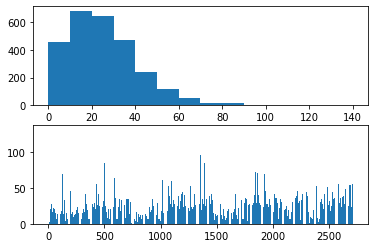

In [7]:
corpus_length_histogram=[]
for i in range(len(corpus_backup)):
    corpus_length_histogram.append(len(corpus_backup[i]))
fig,ax=plt.subplots(2)
ax[0].hist(corpus_length_histogram,list(range(0,max(corpus_length_histogram)+10,10)))
ax[1].bar(list(range(0,len(corpus_backup))),corpus_length_histogram)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"length_histogram.png",bbox_inches='tight', pad_inches=0.01)

In [8]:
#k-mer seperation
def overlaping_kmer(data,k):
    kmer_corpus=[]
    for i in range(len(data)):
        lst=data[i]
        kmer_lst=[]
        for j in range(len(lst)-k+1):
            kmer_lst.append(str(lst[j])+'-'+str(lst[j+1]))
        kmer_corpus.append(kmer_lst)
    return kmer_corpus

In [9]:
def cut_corpus(corpus,cut_length):
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<cut_length:
            new_corpus.append(lst)
            continue
        cut_amount=int((n-n%cut_length)/cut_length)
        for j in range(cut_amount-1):
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus

In [10]:
#corpus=overlaping_kmer(corpus,2)

In [11]:
vocabulary = set(itertools.chain.from_iterable(corpus))
vocabulary_size = len(vocabulary)
print(vocabulary_size)

50


In [12]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [13]:
#corpus=cut_corpus(corpus_backup,60)

In [14]:
def sample_negative(sample_size):
    sample_probability = {}
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus))))
    normalizing = sum([v**0.75 for v in word_counts.values()])
    for word in word_counts:
        sample_probability[word] = word_counts[word]**0.75 / normalizing
    words = np.array(list(word_counts.keys()))
    while True:
        word_list = []
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
        for index, count in enumerate(sampled_index):
            for _ in range(count):
                 word_list.append(words[index])
        yield word_list

In [15]:
# convert to windoes vector

context_tuple_list = []
negative_samples = sample_negative(4)

for text in corpus_backup:
    for i, word in enumerate(text):
        if int(word) in ignore_classes:
            continue
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            if int(text[j]) in ignore_classes:
                continue
            if i!=j:
                context_tuple_list.append((word, text[j], next(negative_samples)))
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

There are 65721 pairs of target and context words


In [16]:
def get_batches(context_tuple_list, batch_size=100):
    random.shuffle(context_tuple_list)
    batches = []
    batch_target, batch_context, batch_negative = [], [], []
    for i in range(len(context_tuple_list)):
        batch_target.append(word_to_index[context_tuple_list[i][0]])
        batch_context.append(word_to_index[context_tuple_list[i][1]])
        batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]])
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
            tensor_target = torch.from_numpy(np.array(batch_target)).long().to(device)
            tensor_context = torch.from_numpy(np.array(batch_context)).long().to(device)
            tensor_negative = torch.from_numpy(np.array(batch_negative)).long().to(device)
            batches.append((tensor_target, tensor_context, tensor_negative))
            batch_target, batch_context, batch_negative = [], [], []
    return batches

In [17]:
class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.target = nn.Embedding(vocab_size, embedding_size).cuda()
        self.context = nn.Embedding(vocab_size, embedding_size).cuda()

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.target(target_word)
        emb_context = self.context(context_word)
        emb_product = torch.mul(emb_target, emb_context).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out = torch.sum(F.logsigmoid(emb_product)).cuda()
        emb_negative = self.context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2)).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out += torch.sum(F.logsigmoid(-emb_product)).cuda()
        return -out

In [18]:
class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        print("Loss gain: {}%".format(gain*100))
        if gain < self.min_gain:
            return True
        else:
            return False
        

In [19]:
embedding_size=100
loss_function = nn.CrossEntropyLoss()
net = Word2Vec(embedding_size=embedding_size, vocab_size=vocabulary_size)
optimizer = optim.Adam(net.parameters())
early_stopping = EarlyStopping(patience=5, min_percent_gain=1)

while True:
    losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=100)
    for i in range(len(context_tuple_batches)):
        net.zero_grad()
        target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
        loss = net(target_tensor, context_tensor, negative_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", torch.mean(torch.stack(losses)),torch.stack(losses)[0],torch.stack(losses)[-1])
    early_stopping.update_loss(torch.mean(torch.stack(losses)))
    if early_stopping.stop() is True:
        break
    if torch.mean(torch.stack(losses))<10:
        break

Loss:  tensor(685.4676, device='cuda:0') tensor(1007.4069, device='cuda:0') tensor(52.3415, device='cuda:0')
Loss:  tensor(276.7143, device='cuda:0') tensor(560.2762, device='cuda:0') tensor(79.5542, device='cuda:0')
Loss gain: 59.63130569458008%
Loss:  tensor(173.6044, device='cuda:0') tensor(143.2613, device='cuda:0') tensor(31.6353, device='cuda:0')
Loss gain: 74.673583984375%
Loss:  tensor(130.5854, device='cuda:0') tensor(160.0979, device='cuda:0') tensor(24.7135, device='cuda:0')
Loss gain: 80.9494400024414%
Loss:  tensor(107.8703, device='cuda:0') tensor(89.1891, device='cuda:0') tensor(27.8807, device='cuda:0')
Loss gain: 84.26325225830078%
Loss:  tensor(95.3104, device='cuda:0') tensor(124.8355, device='cuda:0') tensor(27.3609, device='cuda:0')
Loss gain: 65.55636596679688%
Loss:  tensor(87.8697, device='cuda:0') tensor(81.0791, device='cuda:0') tensor(25.0115, device='cuda:0')
Loss gain: 49.38511657714844%
Loss:  tensor(83.2088, device='cuda:0') tensor(71.8211, device='cuda:0

EMBEDDINGS.shape:  torch.Size([50, 100])
1
2
3
4
5
6
7
8


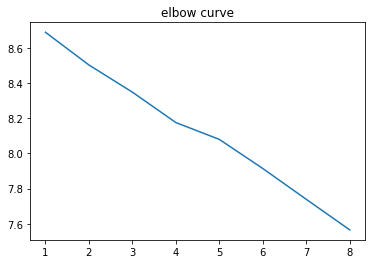

In [20]:
EMBEDDINGS = net.target.weight.data.cpu()
print('EMBEDDINGS.shape: ', EMBEDDINGS.shape)

iris = load_iris()
x = iris.data

res = []
n_cluster = range(1,9)
for n in n_cluster:
    print(n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(EMBEDDINGS)
    res.append(np.average(np.min(cdist(EMBEDDINGS, kmeans.cluster_centers_, 'euclidean'), axis=1)))
        
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

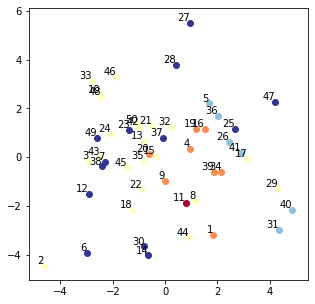

In [21]:
# see the 2D class segments embedding
cluster_number=6
kmeans_best = KMeans(n_clusters=cluster_number).fit_predict(EMBEDDINGS)
pca = PCA(n_components=2).fit_transform(EMBEDDINGS)
EMBEDDINGS = net.target.weight.data.cpu()
EMBEDDINGS_np=np.array(EMBEDDINGS)
plt.figure(figsize = (5, 5))
for i in range(vocabulary_size):
    # print('vocab_idx: ', vocab_idx)
    plt.scatter(pca[i][0], pca[i][1],color=plt.cm.RdYlBu(kmeans_best[i]/4))
    plt.annotate(index_to_word[i], xy = (pca[i][0], pca[i][1]), \
        ha='right',va='bottom')
plt.savefig(output_path+'/'+'w2v.png')
plt.show()

In [22]:
word_to_cluster={}
for i in range(cluster_number):
    word_to_cluster[str(i)]= np.array(np.where(kmeans_best==i)).ravel()+1
#for i in range(1,vocabulary_size+1):
#    word_to_cluster.append((i,kmeans_best[word_to_index[str(i)]]))
print(word_to_cluster)

{'0': array([22], dtype=int64), '1': array([ 5,  7, 11, 16, 23, 31, 35, 46], dtype=int64), '2': array([ 1,  6,  8,  9, 13, 14, 17, 18, 19, 21, 24, 25, 27, 29, 32, 34, 36,
       37, 41, 47, 48, 50], dtype=int64), '3': array([20, 30, 38, 42, 43, 44], dtype=int64), '4': array([ 4, 15, 45], dtype=int64), '5': array([ 2,  3, 10, 12, 26, 28, 33, 39, 40, 49], dtype=int64)}


In [23]:
#using the histogram method to cluster 

#cluster_corpus=corpus[:]
#for i in range(cluster_number):
#    cluster_lst=list(word_to_cluster[str(i)])
#    for j in range(len(cluster_corpus)):
#        filament=cluster_corpus[j]
#        filament=[i if np.int64(x) in cluster_lst else x for x in filament]
#        cluster_corpus[j]=filament

#filament_cluster_percentage=[]
#for filament in cluster_corpus:
#    filament_lenghth=len(filament)
#    pert=[]
#    for i in range(cluster_number):
#        cluster_per=float(filament.count(i))/filament_lenghth
#        pert.append(cluster_per)
#    filament_cluster_percentage.append(pert)

#histogram clustering
#pca_filaments = PCA(n_components=2).fit_transform(filament_cluster_percentage)
#plt.figure(figsize = (5, 5))
#for i in range(len(cluster_corpus)):
#    plt.scatter(pca_filaments[i][0], pca_filaments[i][1],color='blue')
#plt.savefig("cluster.png")
#plt.show()

In [24]:
filament_cluster_number=2
filament_score=[]
all_data=[]
for filament in corpus:
    score=torch.zeros(embedding_size)
    counts=0
    for i in filament:
        if int(i) in ignore_classes:
            continue
        counts+=1
        score=score+EMBEDDINGS[word_to_index[i]]
    if counts==0:
        if filament_score==[]:
            filament_score.append(np.zeros(100))
            continue
        else:
            filament_score.append(filament_score[-1])
            continue
    score=score/counts
    filament_score.append(np.array(score))
all_data=filament_score[:]
all_data.extend(EMBEDDINGS_np)
filament_number=len(filament_score)
print(filament_number)

2711


In [25]:
#print(filament_score)
from sklearn.mixture import GaussianMixture
pca_sum = PCA(n_components=2).fit_transform(all_data)
pca_sum_3D = PCA(n_components=3).fit_transform(all_data)
#cluster_pca = KMeans(n_clusters=3).fit_predict(pca_sum[0:len(corpus)])

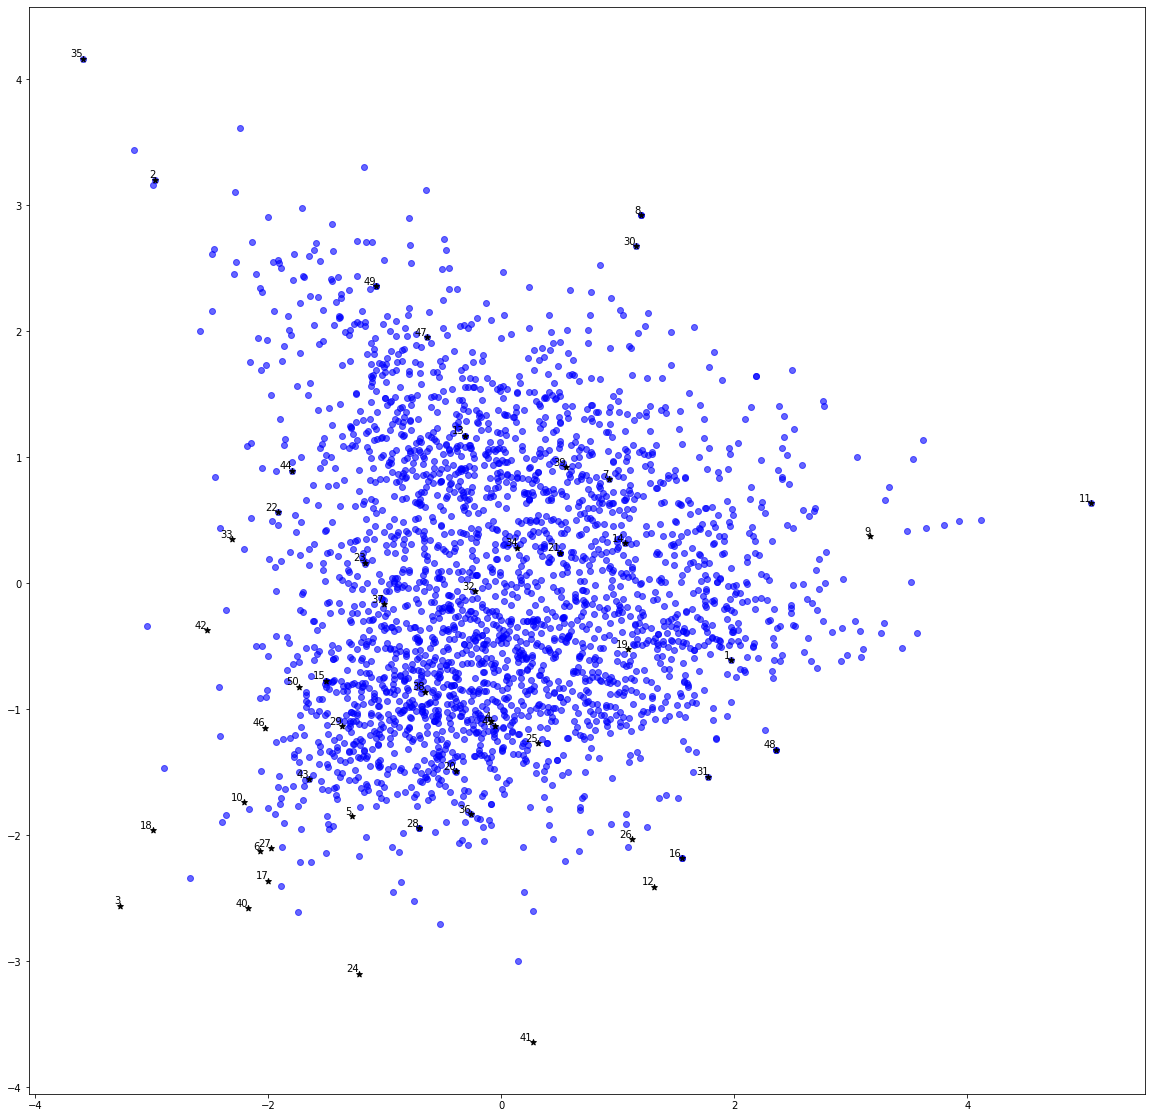

In [26]:
plt.figure(figsize = (20, 20))
for i in range(len(corpus)):
    plt.scatter(pca_sum[i][0], pca_sum[i][1],alpha=0.6,color='blue')
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(pca_sum[i+filament_number][0], pca_sum[i+filament_number][1],color='black',marker='*')
    plt.annotate(index_to_word[i], xy = (pca_sum[i+filament_number][0], pca_sum[i+filament_number][1]), ha='right',va='bottom')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_pca.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.RdYlBu(pca_Clustering[i]/4)

In [62]:
import umap
import sklearn
from sklearn.cluster import SpectralClustering,MeanShift, estimate_bandwidth,AgglomerativeClustering
import matplotlib.patches as mpatches
n_neighbors=100
min_dist=0
reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist)
reducer_3D = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=3)
umap = reducer.fit_transform(all_data)
umap_3D = reducer_3D.fit_transform(all_data)
filament_umap=umap[0:filament_number]
filament_umap_3D=umap_3D[0:filament_number]
print('finish umap')

filament_cluster_number=3
umap_predict=SpectralClustering(n_clusters=filament_cluster_number).fit_predict(filament_umap)
#cluster_umap =  KMeans(n_clusters=filament_cluster_number).fit(umap[0:filament_number])
#cluster_umap = AgglomerativeClustering(n_clusters=filament_cluster_number,distance_threshold=None).fit(umap[0:filament_number])
#umap_predict=cluster_umap.fit_predict(filament_umap)
print('finish')


finish umap
finish


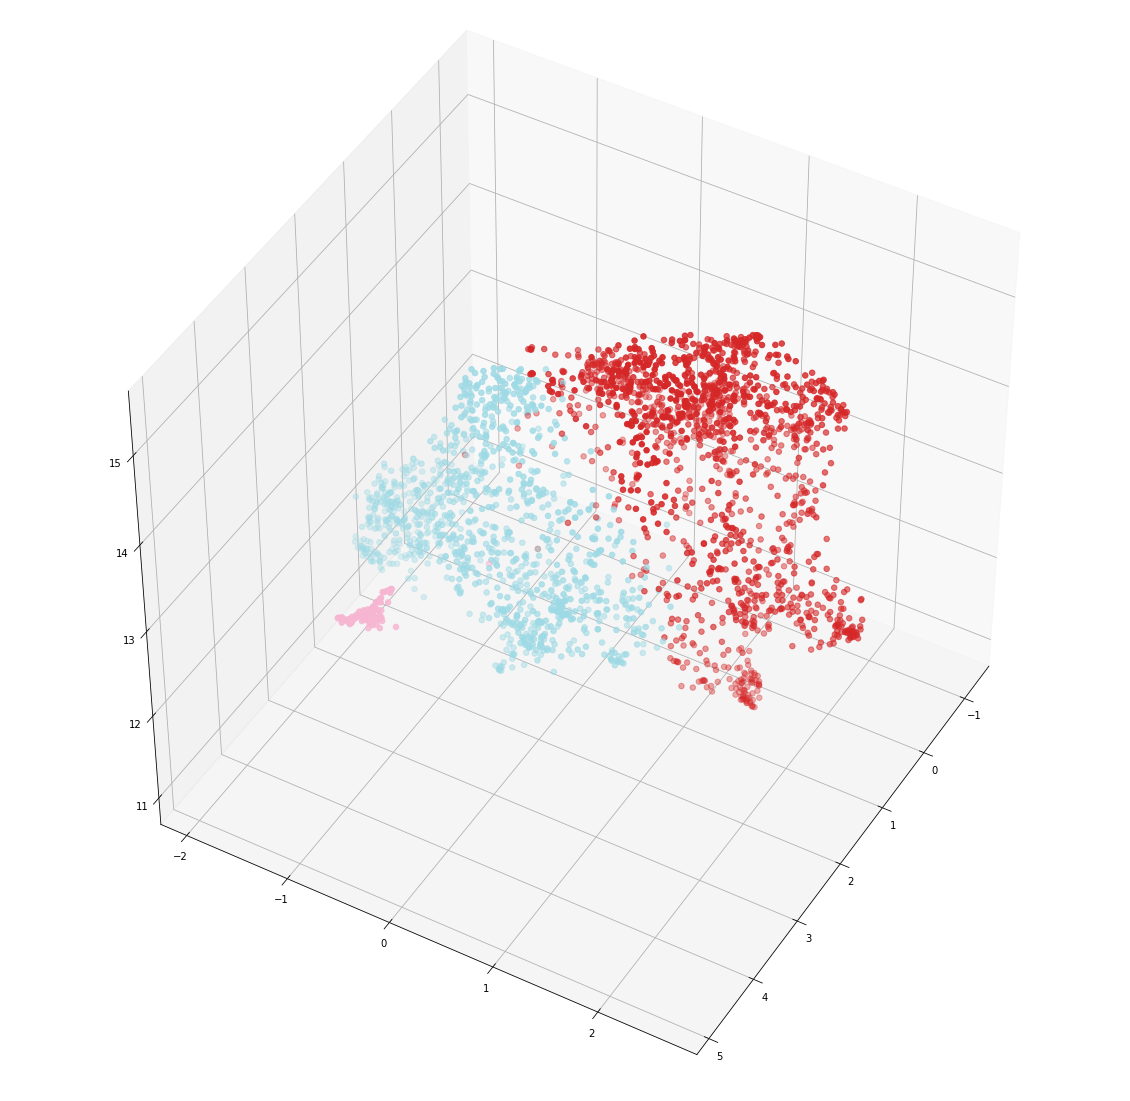

In [63]:
# 3 dimensional umap
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(filament_umap_3D[:,0], filament_umap_3D[:,1], filament_umap_3D[:,2], c=plt.cm.tab20((umap_predict+1)/filament_cluster_number), s=30)
ax.view_init(45,30)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_3D.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

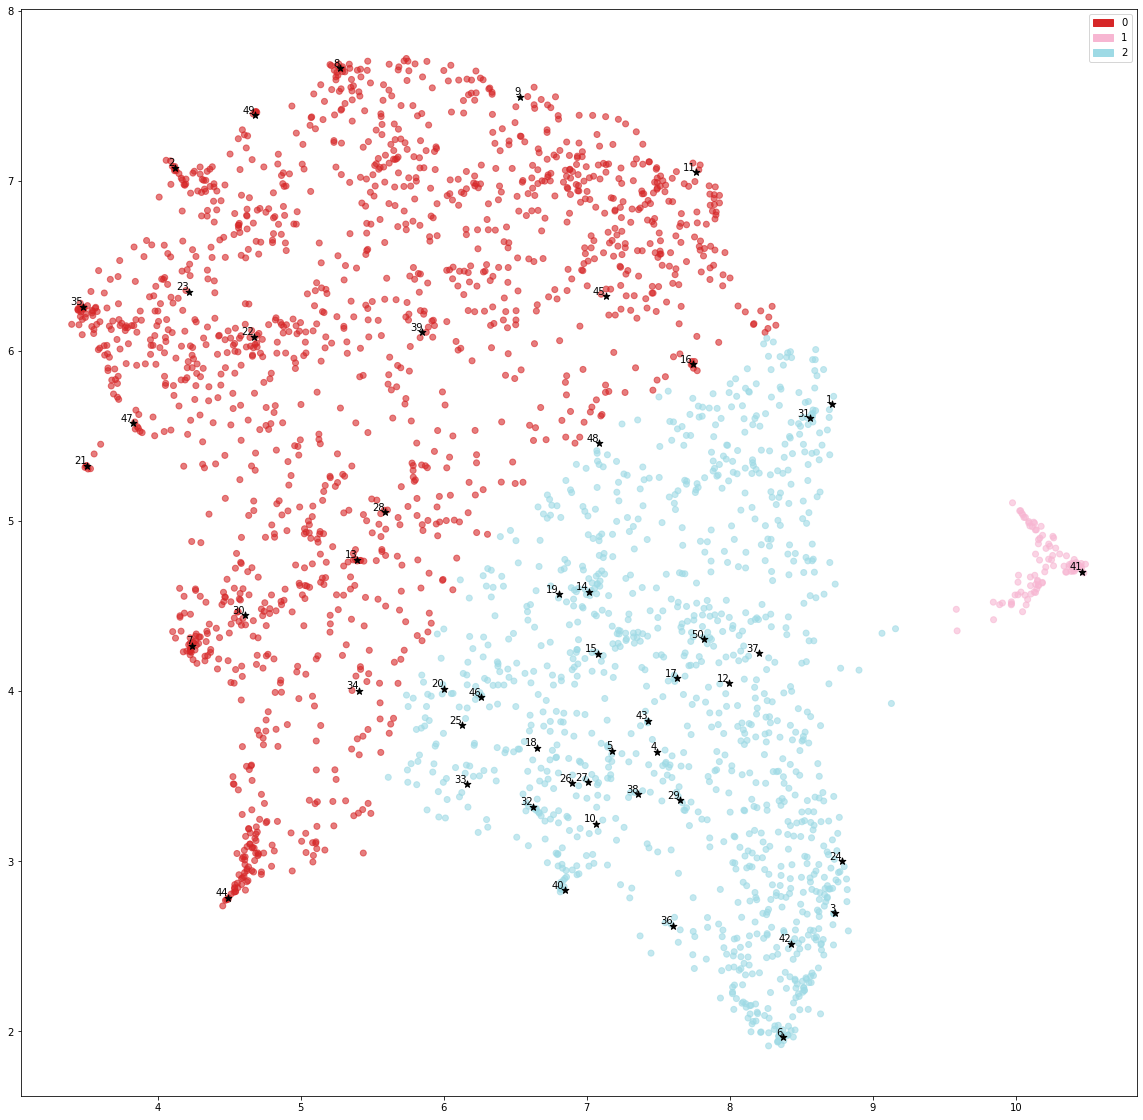

In [64]:
plt.figure(figsize = (20, 20))
for i in range(filament_cluster_number):
    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i+1)/filament_cluster_number), label=str(i))
plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
plt.scatter(filament_umap[:,0], filament_umap[:,1],alpha=0.6,color=plt.cm.tab20((umap_predict+1)/filament_cluster_number))
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(umap[i+filament_number][0], umap[i+filament_number][1],color='black',marker='*',s=50)
    plt.annotate(index_to_word[i], xy = (umap[i+filament_number][0], umap[i+filament_number][1]), ha='right',va='bottom')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.RdYlBu((umap_predict[i]+1)/filament_cluster_number)

In [65]:
#seperate cluster
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    cluster_nameID='clusterID'+str(i)
    locals()[cluster_name]=[]
    locals()[cluster_nameID]=[]
data_line=0
cluster_choice=umap_predict
positive_label=[]
for i in range(len(cluster_choice)):
    lst=corpus[i]
    cluster_number=cluster_choice[i]
    cluster_name='cluster'+str(cluster_number)
    cluster_nameID='clusterID'+str(cluster_number)
    for j in range(len(lst)):
        locals()[cluster_name].append(data[data_line])
        locals()[cluster_nameID].append(data[data_line][6][19:21])
        data_line+=1
    positive_label.append(locals()[cluster_nameID][-1]) 

In [35]:
# histogram on rate of successful
labels=['38','29'] #tau 10230
distribution_hist_all=[]
for i in range(filament_cluster_number):
    distribution_hist=[]
    lst=locals()['clusterID'+str(i)]
    for j in range(filament_cluster_number):
        group_percentage=lst.count(labels[j])/len(lst)
        distribution_hist.append(group_percentage)
    distribution_hist_all.append(distribution_hist)
print(distribution_hist_all)
print(len(data),len(cluster0),len(cluster1))

fig, ax = plt.subplots(1,filament_cluster_number)
labels_name=['PHF','SF']
for i in range(filament_cluster_number):
    ax[i].bar(range(filament_cluster_number),distribution_hist_all[i],tick_label =labels_name)
    particle_number=len(locals()['cluster'+str(i)])
    ax[i].set_title('cluster{} amount: {}'.format(i,particle_number))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+'distr_new.png')
print('a')

IndexError: list index out of range

In [ ]:
#label distribution
plt.figure(figsize = (20, 20))
print(len(positive_label))
for i in range(len(corpus)):
    plt.scatter(umap[i][0], umap[i][1],color=plt.cm.RdYlBu(float(positive_label[i])/38))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_labels.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [ ]:
#seperarte subcluster
for i in range(filament_cluster_number):
    cluster=locals()['cluster'+str(i)]
    lst=locals()['clusterID'+str(i)]
    for j in range(filament_cluster_number):
        subcluster_name='cluster'+str(i)+'_'+str(j)
        locals()[subcluster_name]=[x for x, y in zip(cluster,lst) if y==labels[j]]

In [ ]:
# write relion

In [66]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    data_cluster=locals()[cluster_name]
    if datatype==0:
        output=process_relion.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.opticgroup(optics)
        output.writecluster()
    elif datatype==1:
        output=process_relion.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.writemetadata()
        output.writecluster()

In [ ]:
# write subcluster relion
for i in range(filament_cluster_number):
    for j in range(filament_cluster_number):
        cluster_name='cluster'+str(i)+'_'+str(j)
        data_cluster=locals()[cluster_name]
        if datatype==0:
            output=process_relion.output_star(output_path+'/'+file_name,str(i)+'_'+str(j),data_cluster,metadata)
            output.opticgroup(optics)
            output.writecluster()
        elif datatype==1:
            output=process_relion.output_star(output_path+'/'+file_name,str(i)+'_'+str(j),data_cluster,metadata)
            output.writemetadata()
            output.writecluster()

In [ ]:
with open('cluster_umap.npy', 'wb') as f:
    np.save(f, umap)